In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time, sys
from extra_geom import AGIPD_1MGeometry
import extra_data as ex
import h5netcdf
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [2]:
def get_cf(darr,skip_last=0):
    return np.array([np.nanmean(np.diagonal(darr,offset=i)) for i in range(1,len(darr)-skip_last)])

def Decay_Curve(dt,Gm,beta,off):
    g1 = np.exp(-Gm*dt) #Gm relaxation rate -> Gm = q**2 * D
    g2 = beta*g1**2+off
    return g2

def Dq(q,D):
    return D*q**2

def Dq_bkg(q,D,bkg):
    return D*q**2+bkg

def gauss(x, A, x0, sigma, bkg): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + bkg


In [3]:
proposal = 900401
#run_no = 450

run_no = [422,423,424, 425] #422-424 Si NP 20nm, 425 LUDOX

ludox_runs = [425, 426, 427, 428]

qROI = range(14)

In [4]:
def get_data(run_no):
    
    qROI = range(14)

    loc = '/gpfs/exfel/exp/MID/202430/p{}/scratch/xpcs/r0'.format(proposal)
    outputloc = loc+str(run_no)+'/'

    TTCF = xr.open_dataarray(outputloc+'TTCF.nc')
    SAXS = xr.open_dataarray(outputloc+'SAXS.nc')
    g2 = xr.open_dataarray(outputloc+'g2.nc')
    pulseN = TTCF.pulse_1.values
    dt = pulseN[:-1]*222.5e-9 * 2
    q = np.array(TTCF.qBin[qROI])
    
    return TTCF, SAXS, g2, pulseN, dt, q

In [5]:
TTCF_422, SAXS_422, g2_422, pulseN_422, dt_422, q_422 = get_data(run_no[0])
TTCF_423, SAXS_423, g2_423, pulseN_423, dt_423, q_423 = get_data(run_no[1])
TTCF_424, SAXS_424, g2_424, pulseN_424, dt_424, q_424 = get_data(run_no[2])

In [6]:
TTCF_422.shape

(14, 100, 100)

In [7]:
TTCF_422[0].shape

(100, 100)

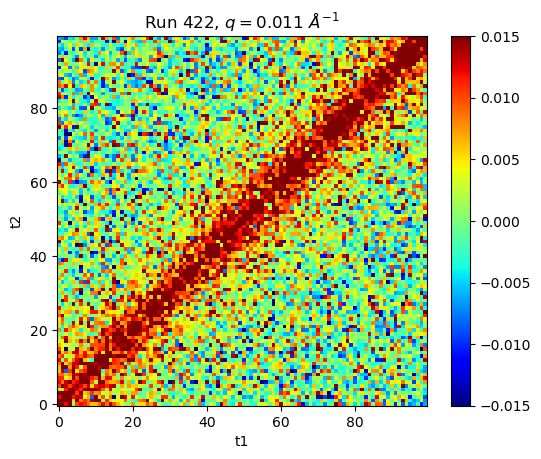

In [8]:
plt.imshow((TTCF_422[0]), vmin = -0.015, vmax = 0.015,  origin = 'lower', cmap = 'jet')
plt.colorbar()
plt.title(r'Run 422, $q = 0.011$ $Å^{-1}$')
plt.xlabel('t1')
plt.ylabel('t2')
plt.savefig('Sim/pics/TTCF_422_0.png', dpi = 300)

In [9]:
def g2_func(TTCF):
    g22 = []
    for i in range(len(TTCF)):
        g2 = get_cf(TTCF[i])
        g22.append(g2)
    return g22


In [10]:
g2_422 = g2_func(TTCF_422)
g2_423 = g2_func(TTCF_423)
g2_424 = g2_func(TTCF_424)

In [11]:
q_422

array([0.01075, 0.01325, 0.01575, 0.01825, 0.02075, 0.02325, 0.02575,
       0.02825, 0.03075, 0.03325, 0.03575, 0.03825, 0.04075, 0.04325])

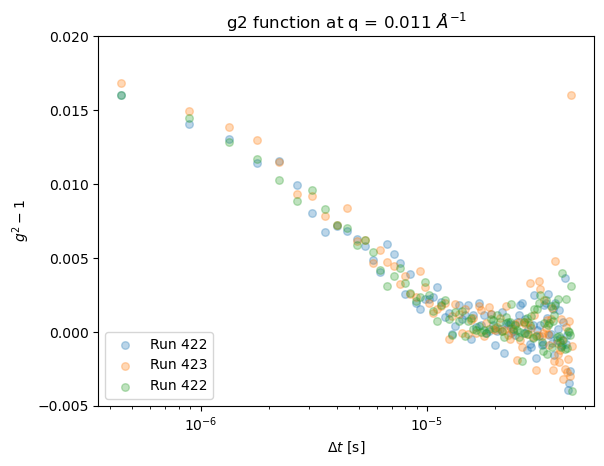

In [12]:
plt.scatter(dt_422, g2_422[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 422')
plt.scatter(dt_423, g2_423[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 423')
plt.scatter(dt_424, g2_424[0], s = 30, alpha = 0.3, marker = 'o', label = 'Run 422')
plt.xscale('log')
plt.xlabel(r'$\Delta t $ [s]')
plt.ylabel(r'$g^{2} - 1$')
plt.ylim(-0.005,0.02)
plt.legend()
plt.title(r'g2 function at q = 0.011 $Å^{-1}$')
plt.savefig('g2_func_3_runs.png', dpi = 300)

In [13]:
def get_coef(g2, dt):

    b = []
    gm = []
    k = []
    unc = []
    
    for i in range(len(q_422)):
        def chi2(Gm, beta, off):
            y_exp = Decay_Curve(dt, Gm, beta, off)
            chi2 = np.sum(((g2[i] - y_exp) / np.std(g2[i]))**2)
            
            return chi2
        fit = Minuit(chi2, beta = g2[i][0], Gm = 5, off = min(g2[i]))
        fit.migrad();
        Gm, beta, off = fit.values
            
        unc.append(fit.errors)
        gm.append(Gm)
        b.append(beta)
        k.append(off)
        
    return gm, b, k, np.array(unc)

In [14]:
gm_422, b_422, k_422, unc_422 = get_coef(g2_422, dt_422)
gm_423, b_423, k_423, unc_423 = get_coef(g2_423, dt_423)
gm_424, b_424, k_424, unc_424 = get_coef(g2_424, dt_424)

In [15]:
unc_422

array([[2.38615171e+04, 2.25878639e-03, 5.74186976e-04],
       [3.41339693e+04, 2.34342182e-03, 4.22716289e-04],
       [4.59902238e+04, 2.22348018e-03, 3.41919401e-04],
       [6.37537370e+04, 2.36170713e-03, 3.21336263e-04],
       [1.03216378e+05, 1.88744930e-03, 2.35583398e-04],
       [1.02609466e+05, 1.29839102e-03, 1.54593711e-04],
       [1.36270200e+05, 1.16768173e-03, 1.30102334e-04],
       [3.07616719e+05, 1.38221005e-03, 1.45358024e-04],
       [1.62569026e+03, 3.57357874e-03, 3.56945886e-03],
       [1.76902746e+04, 1.10255519e-02, 1.12858782e-02],
       [4.12673488e+04, 2.53699039e-04, 7.36199663e-04],
       [1.94936957e+03, 3.32836058e-03, 3.32547604e-03],
       [1.64183263e+03, 2.60766220e-03, 2.60742619e-03],
       [1.24556060e+04, 9.86184560e-09, 2.43695633e-04]])

In [16]:
for i in range(len(gm_422)):
    print('gm:', 1/gm_422[i], 'pm', 1/unc_422[i][0])
    

gm: 1.0290574923743261e-05 pm 4.190848362295559e-05
gm: 6.210312140549432e-06 pm 2.9296329137756196e-05
gm: 4.627791886076939e-06 pm 2.1743751566537993e-05
gm: 3.5007420932523137e-06 pm 1.5685355028865285e-05
gm: 2.7390652145770645e-06 pm 9.688384914810026e-06
gm: 2.255919322244019e-06 pm 9.745689536969385e-06
gm: 1.7311760815649377e-06 pm 7.338361555073217e-06
gm: 1.1865991718728256e-06 pm 3.2507985997903444e-06
gm: -0.0009001821393616516 pm 0.0006151233269850695
gm: -0.0002946200865053944 pm 5.652823510417988e-05
gm: -2.6001255657520748e-05 pm 2.423223270875632e-05
gm: -0.023884662342979784 pm 0.0005129863605633473
gm: -0.0023259018924305383 pm 0.0006090754818789627
gm: -6.773563356024905e-06 pm 8.028513416296311e-05


In [81]:
q_422[7]**2

0.0007980625000000003

In [82]:
q_422

array([0.01075, 0.01325, 0.01575, 0.01825, 0.02075, 0.02325, 0.02575,
       0.02825, 0.03075, 0.03325, 0.03575, 0.03825, 0.04075, 0.04325])

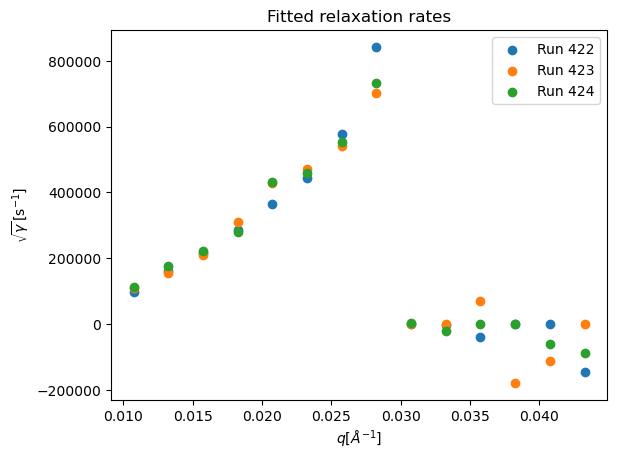

In [18]:
plt.scatter(q_422, (gm_422), label = 'Run 422')
plt.scatter(q_423, (gm_423), label = 'Run 423')
plt.scatter(q_424, (gm_424), label = 'Run 424')
plt.ylabel(r'$\sqrt{\gamma} \, [\mathrm{s}^{-1}]$')
plt.xlabel(r'$q [Å^{-1}]$')
plt.legend()
plt.title('Fitted relaxation rates')
plt.savefig('r_rates_silica.png', dpi = 300)

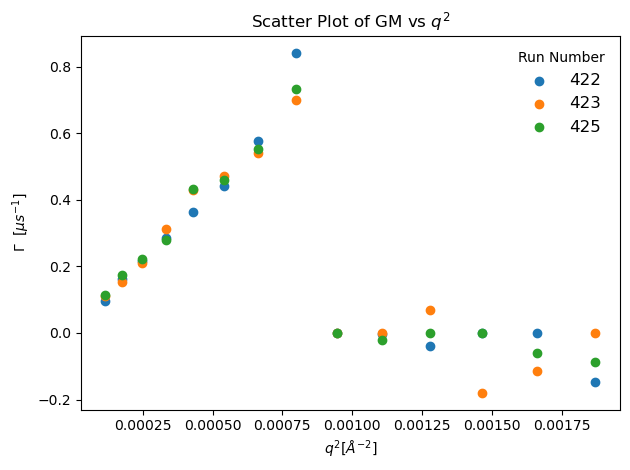

In [79]:
runss = [422, 423, 425]

for i in range(len(gm)):
    dy = exp(Ds[i], qd * 1e10) / 1e6
    
    plt.scatter(q_422**2 , (gm[i] / 1e6), label = '{}'.format(runss[i]))
plt.xlabel(r'$q^{2} [Å^{-2}]$')
plt.ylabel('$\Gamma$  [$\mu s^{-1}$]')
plt.legend(title="Run Number", fontsize=12, loc='upper right', frameon=False)
plt.title('Scatter Plot of GM vs $q^2$')
#plt.xticks(rotation=45, fontsize=12);
plt.savefig('Sim/pics/gamma_q2_1.png', dpi = 300)
plt.tight_layout()

Important q values are q[0:8]

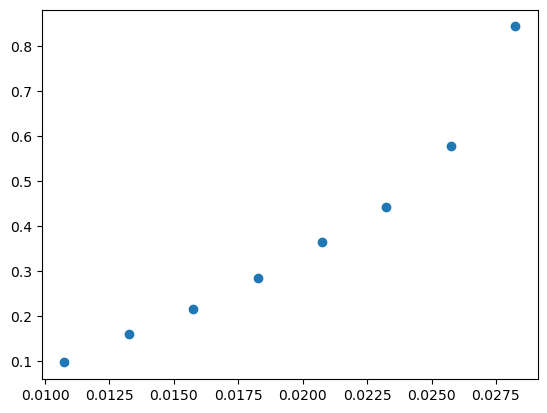

In [20]:
plt.scatter(q_422[0:8], np.array(gm_422)[0:8] / 1e6 )

In [21]:
gm = np.vstack([gm_422, gm_423, gm_424])
gm_unc = np.vstack([unc_422[:,0], unc_423[:,0], unc_424[:,0]])

qq = q_422

qd = np.linspace(0, qq[8], 100)

In [22]:
gm[0]

array([ 9.71763004e+04,  1.61022502e+05,  2.16085776e+05,  2.85653720e+05,
        3.65088058e+05,  4.43278264e+05,  5.77641992e+05,  8.42744563e+05,
       -1.11088629e+03, -3.39420171e+03, -3.84596811e+04, -4.18678726e+01,
       -4.29940748e+02, -1.47632782e+05])

Text(0, 0.5, '$\\Gamma$  [$\\mu s^{-1}$]')

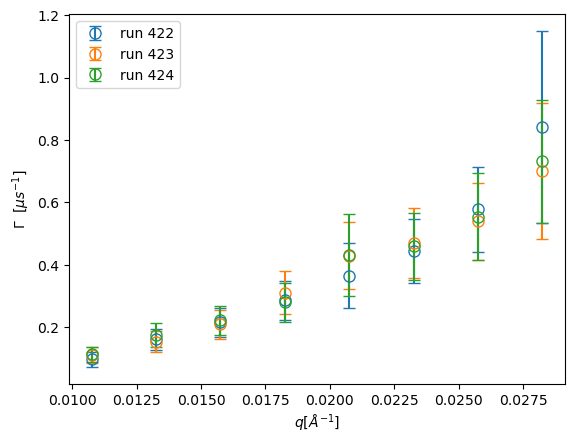

In [23]:
plt.figure()
for i in range(len(gm)):
    plt.errorbar(qq[0:8], gm[i][0:8] / 1e6, gm_unc[i][0:8] / 1e6, fmt = 'o',
                markersize = 8, markeredgewidth = 1, markerfacecolor = 'None', capsize = 4, label = 'run {}'.format(422 + i))
plt.legend()
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('$\Gamma$  [$\mu s^{-1}$]')

In [24]:
q_422

array([0.01075, 0.01325, 0.01575, 0.01825, 0.02075, 0.02325, 0.02575,
       0.02825, 0.03075, 0.03325, 0.03575, 0.03825, 0.04075, 0.04325])

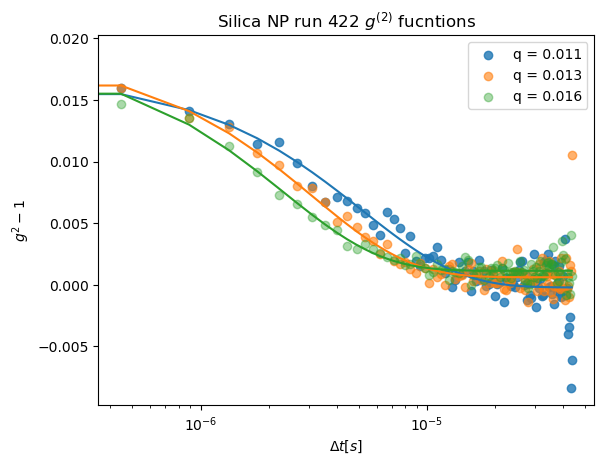

In [25]:
alpha = [0.8, 0.6, 0.4]
for i in range(3):
    plt.scatter(dt_422, g2_422[i], alpha = alpha[i], label = 'q = {}'.format(np.round(q_422[i], 3)))
    plt.plot(dt_422, Decay_Curve(dt_422, gm_422[i], b_422[i], k_422[i]))
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta t [s]$')
plt.ylabel(r'$g^{2} - 1$')
plt.title(r'Silica NP run 422 $g^{(2)}$ fucntions')
plt.savefig('Sim/pics/run_422_g2_3.png', dpi = 300)

In [26]:
gm[i][0:8] / 1e6

array([0.11315546, 0.17556645, 0.22161273, 0.27964569, 0.43136654,
       0.45958819, 0.5538324 , 0.73221124])

## Fitting Diffusion coeff

In [27]:
def exp(D, q):
    return D * q ** 2

In [28]:
def line(m,x,b):
    y = m * x + b
    return y

In [29]:
def chi2(D):
    y = exp(D, qq[0:8] * 1e10)
    chi2 = np.sum((gm[0][0:8] - y) ** 2 / gm_unc[0][0:8] ** 2)
    return chi2

fitd = Minuit(chi2, D = 1)
fitd.migrad();
dd = fitd.values

In [30]:
Ds = []
idk = []
chii = []

for i in range(len(gm)):
    def chi2(D):
        y = exp(D, qq[0:8] * 1e10)
        chi2 = np.sum((gm[i][0:8] - y) ** 2 / gm_unc[i][0:8] ** 2)
        return chi2
    fit = Minuit(chi2, D = 1)
    fit.migrad();
    dd = fit.values
    err = fit.errors
    Ds.append(dd)
    idk.append(err)
    chii.append(fit.fval)


    

In [31]:
for i in range(len(Ds)):
    print(Ds[i], r'$\pm$', idk[i])

<ValueView D=8.687314062825542e-12> $\pm$ <ErrorView D=7.415436563294505e-13>
<ValueView D=8.867150017266116e-12> $\pm$ <ErrorView D=7.435120804840636e-13>
<ValueView D=9.04048426820628e-12> $\pm$ <ErrorView D=7.505293433962131e-13>


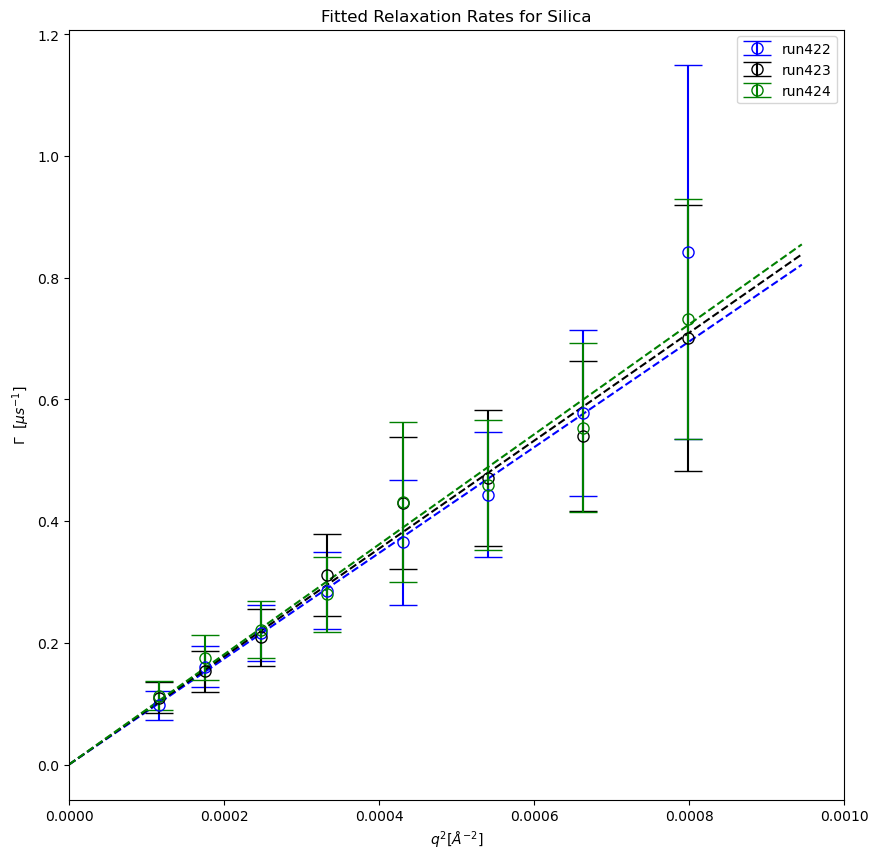

In [32]:
colors = ['blue', 'black', 'green']
alpha = [0.4, 0.6, 0.8]
plt.figure(figsize = (10,10))
for i in range(len(gm)):
    dy = exp(Ds[i], qd * 1e10) / 1e6
    
    plt.errorbar(qq[0:8]**2 , (gm[i][0:8] / 1e6), gm_unc[i][0:8] / 1e6,
                fmt = 'o',markersize = 8, markeredgewidth = 1, color = colors[i], capsize = 10,
                markerfacecolor = 'None', label = 'run{}'.format(run_no[i]))
    plt.plot(qd ** 2, (dy), color = colors[i], ls = '--')
    
plt.legend()
plt.xlabel(r'$q^{2} [Å^{-2}]$')
plt.ylabel('$\Gamma$  [$\mu s^{-1}$]')
plt.xlim(0.00, 0.001)
plt.title('Fitted Relaxation Rates for Silica')
plt.savefig('Sim/pics/silica_d_fit_straight_line.png', dpi = 300)

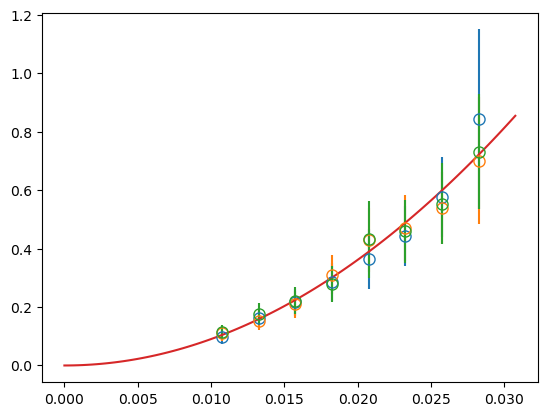

In [33]:
dfit_y = exp(dd, qd*1e10) / 1e6

for i in range(len(gm)):
    plt.errorbar(qq[0:8], gm[i][0:8] / 1e6, gm_unc[i][0:8] / 1e6, fmt = 'o',
                markersize = 8, markeredgewidth = 1, markerfacecolor = 'None')
plt.plot(qd, dfit_y)
#plt.xlim(0.009,0.031)

In [34]:
np.array(Ds) * 1e12

array([[8.68731406],
       [8.86715002],
       [9.04048427]])

In [35]:
Ds

[<ValueView D=8.687314062825542e-12>,
 <ValueView D=8.867150017266116e-12>,
 <ValueView D=9.04048426820628e-12>]

In [36]:
np.array(idk) * 1e12

array([[0.74154366],
       [0.74351208],
       [0.75052934]])

In [37]:
np.array(chii)

array([0.39327515, 0.54949031, 0.74337903])

## Calclulate radius

In [38]:
Kb = 1.38 * 1e-23
T = 290
eta = 0.001
pi = np.pi

# R = (kB T) / (D_0 6 pi eta)

def R(D):
    R = (Kb * T) / (np.array(D) * 6 * pi * eta) 
    return R

def uncR(D, sigma_D):
    return (Kb * T) / (6 * pi * eta * (np.array(D)) ** 2) * sigma_D


In [39]:
Ds

[<ValueView D=8.687314062825542e-12>,
 <ValueView D=8.867150017266116e-12>,
 <ValueView D=9.04048426820628e-12>]

In [40]:
for i in range(len(Ds)):
    print(R(Ds[i]) * 1e9, '\u00B1' , uncR(Ds[i], idk[i]) * 1e9) # how much energy is applied - look at absorbtion of water # super heating
#temp increase ca 10

[24.43939433] ± [2.08613131]
[23.94373544] ± [2.00768641]
[23.48465943] ± [1.94966613]


## SAXS

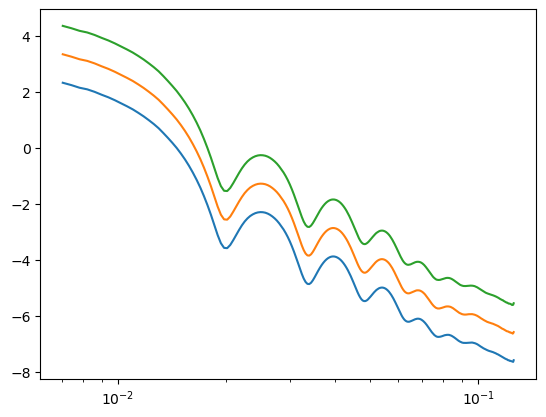

In [41]:
d_sax = ([SAXS_422, SAXS_423, SAXS_424])
for i in range(len(d_sax)):
    qq = SAXS_422.coords['q'].values
    sax = np.mean(d_sax[i], axis = 0) 
    plt.plot(qq, (np.log(sax) + i))
    plt.xscale('log')


In [42]:
d_sax[0].shape 

(100, 300)

In [43]:
qq

array([0.00702191, 0.00741788, 0.00781385, 0.00820982, 0.00860578,
       0.00900175, 0.00939772, 0.00979369, 0.01018966, 0.01058562,
       0.01098159, 0.01137756, 0.01177353, 0.0121695 , 0.01256546,
       0.01296143, 0.0133574 , 0.01375337, 0.01414933, 0.0145453 ,
       0.01494127, 0.01533724, 0.01573321, 0.01612917, 0.01652514,
       0.01692111, 0.01731708, 0.01771304, 0.01810901, 0.01850498,
       0.01890095, 0.01929692, 0.01969288, 0.02008885, 0.02048482,
       0.02088079, 0.02127676, 0.02167272, 0.02206869, 0.02246466,
       0.02286063, 0.02325659, 0.02365256, 0.02404853, 0.0244445 ,
       0.02484047, 0.02523643, 0.0256324 , 0.02602837, 0.02642434,
       0.0268203 , 0.02721627, 0.02761224, 0.02800821, 0.02840418,
       0.02880014, 0.02919611, 0.02959208, 0.02998805, 0.03038402,
       0.03077998, 0.03117595, 0.03157192, 0.03196789, 0.03236385,
       0.03275982, 0.03315579, 0.03355176, 0.03394773, 0.03434369,
       0.03473966, 0.03513563, 0.0355316 , 0.03592756, 0.03632

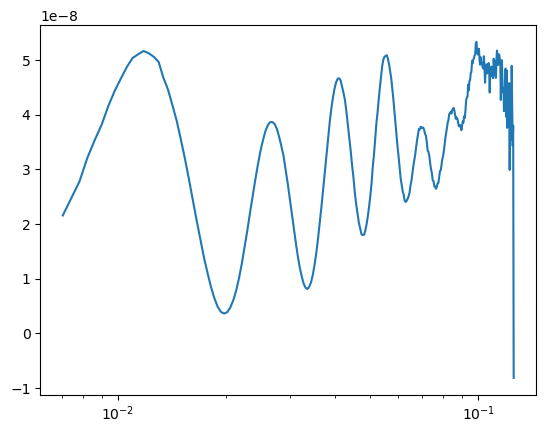

In [44]:
qq = SAXS_422.coords['q'].values
plt.plot(qq, (d_sax[0][0] - 2.5e-4) * qq**4)
plt.xscale('log')
#plt.yscale('log')

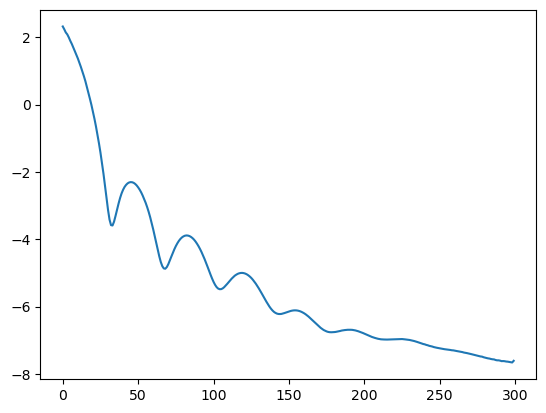

In [45]:
plt.plot(np.mean(np.log(SAXS_422), axis = 0))

In [46]:
len(SAXS_422[0])

300

In [47]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(SAXS_422[0] * -1, distance = 20)
peaks
saxs_q = SAXS_422.coords['q'].values

In [48]:
peaks

array([ 33,  67, 104, 144, 178, 214, 246, 269, 291])

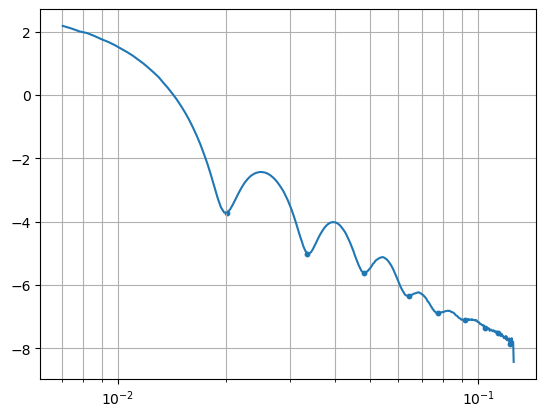

In [49]:
plt.plot(saxs_q, np.log(SAXS_422[0,:]))
plt.scatter(saxs_q[peaks], np.log(SAXS_422[0][peaks]), s = 10)
plt.xscale('log')
plt.grid(which = 'both')


In [50]:
4.49 / saxs_q[peaks[0]] * 1e-1

22.350705090796055

In [51]:
from scipy.optimize import curve_fit

def guinier_fit(q, logI0, Rg):
    return logI0 - (Rg ** 2 / 3) * q ** 2

def form_factor(q, R):
    iq = (3 * ( np.sin(q * R) - q * R * np.cos(q * R)) / ((q * R) ** 3))
    return iq

logI = np.log(SAXS_422[0])
int422 = SAXS_422[0]

popt, pcov = curve_fit(guinier_fit, saxs_q, SAXS_422[0], p0=[20,1])

popi, pcovi = curve_fit(form_factor, saxs_q, int422, p0 = 1)

logI0, Rg = popt
Rg_error = np.sqrt(pcov[1, 1])

In [52]:
popi

array([112.0621794])

In [53]:
#sasview = np.vstack([saxs_q, int422])
#np.array(int422).tofile('Sim/samples/int422.dat', sep = ',')

In [54]:
import pandas as pd

sax = np.mean(d_sax[2], axis = 0)

d = {'q': saxs_q, 'I(q)': np.array(sax)}

sasdf = pd.DataFrame(data = d)
sasdf.to_csv('Sim/samples/424_mean.dat', index = False)

NameError: name 'sphere' is not defined

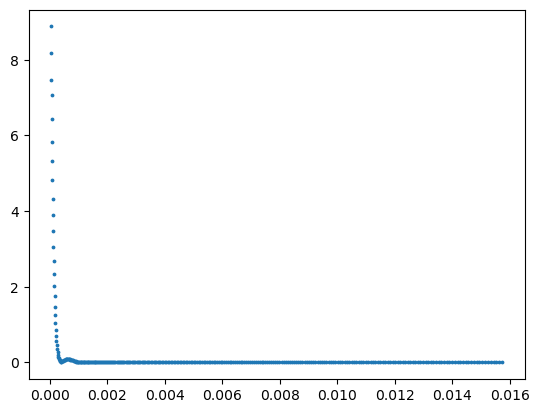

In [55]:
plt.scatter(saxs_q ** 2, int422, label='Data', s = 3)
plt.plot(saxs_q ** 2 , (sphere(saxs_q, *popi)), label='Fit', c = 'orange')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$q^2$ (Å$^{-2}$)')
plt.ylabel(r'$\ln(I(q))$')
plt.legend()
plt.show()

In [ ]:
max(1/saxs_q)

In [ ]:
plt.scatter(saxs_q ** 2, (logI), label='Data', s = 5)
plt.plot(saxs_q ** 2, (form_factor(saxs_q, *popi)))
plt.xscale('log')
plt.xlabel(r'$q^2$ (Å$^{-2}$)')
plt.ylabel(r'$\ln(I(q))$')
plt.legend()
plt.show()

In [ ]:
r_saxs = np.sqrt(5/3 * Rg)
r_saxs

In [ ]:
plt.imshow(np.log(SAXS_422))

In [ ]:
saxs_extent = [min(saxs_q), max(saxs_q), min(np.log(np.mean(SAXS_422, axis = 0))), max(np.log(np.mean(SAXS_422, axis = 0)))]

plt.imshow(np.log(SAXS_422), extent=saxs_extent, origin='lower', cmap='viridis', alpha=0.7, aspect='auto')
plt.plot(saxs_q, np.log(np.mean(SAXS_422, axis = 0)), color = 'red')
plt.plot(saxs_q, np.log(np.mean(SAXS_423, axis = 0)), color = 'yellow')
plt.xlabel(r'$q^2$ (Å$^{-2}$)')
plt.ylabel(r'$\ln(I(q))$')
plt.ylim(saxs_extent[2], saxs_extent[3])

## the rest is whack

In [ ]:
#Minuit fit

def D_fit(q,gm, unc):
    
    def d_chi2(D):
        y = Dq(D, q*1e10)
        chi2 = np.sum(((gm - y) / unc) ** 2)
        return chi2
    
    d_fit = Minuit(d_chi2, D = 1)
    d_fit.migrad()
    d = d_fit.values
    d_err = d_fit.errors
    
    return d, d_err

In [ ]:
unc_422[:,0]

In [ ]:
#scipy

Dsc_422, cov_422 = curve_fit(Dq, qq, gm_422[0:8], p0 = 1e-12, sigma = unc_422[:,0][0:8])


In [ ]:
print(Dsc_422, D_422)

In [ ]:
D_422 = D_fit(q_422[0:8], np.array(gm_422)[0:8] , unc_422[:,0][0:8])
D_423 = D_fit(q_423[0:8], np.array(gm_423)[0:8] , unc_423[:,0][0:8])
D_424 = D_fit(q_424[0:8], np.array(gm_424)[0:8] , unc_424[:,0][0:8])

print('Diff:', D_422)
print('Diff:', D_423)
print('Diff:', D_424)

In [ ]:
d_fit22 = Dq(qd , D_422[0]) 
d_fit23 = Dq(qd , D_423[0]) 
d_fit24 = Dq(qd , D_422[0])

In [ ]:
plt.errorbar(qq, np.array(gm_422)[0:8] / 1e6 , unc_422[:,0][0:8] / 1e6, fmt = 'o',
            markersize = 8, markeredgewidth = 1, markerfacecolor = 'None')
plt.errorbar(qq, np.array(gm_423)[0:8] / 1e6, unc_423[:,0][0:8] / 1e6, fmt = 'o',
            markersize = 8, markeredgewidth = 1, markerfacecolor = 'None')
plt.errorbar(qq, np.array(gm_424)[0:8] / 1e6, unc_424[:,0][0:8] / 1e6, fmt = 'o',
            markersize = 8, markeredgewidth = 1, markerfacecolor = 'None')
plt.plot(qd,d_fit22)
#plt.plot(qd,d_fit23)
#plt.plot(qd,d_fit24)
plt.xlabel('q')
plt.ylabel('gamma')
#plt.ylim(0,0.2)

In [ ]:
#samples in water

In [ ]:
d_fit22 

In [ ]:
def D_fit_line(q,gm, unc):
    
    def d_chi2(D, b):
        y = line(D, q*1e10, b)
        chi2 = np.sum(((gm - y) / unc) ** 2)
        return chi2
    
    d_fit = Minuit(d_chi2, D = 1, b = 0)
    d_fit.migrad()
    d, b = d_fit.values
    d_err, b_err = d_fit.errors
    
    return d,b, d_err, b_err

In [ ]:
Dl_422 = D_fit_line(q_422[0:8], (gm_422[0:8]), unc_422[:,0][0:8])

In [ ]:
Dl_422

In [ ]:
dl_fit22 = line(qd * 1e10, Dl_422[0], 0) / 1e6

In [ ]:
plt.plot(qd, dl_fit22)
plt.errorbar(qq, np.array(gm_422)[0:8] / 1e6 , unc_422[:,0][0:8] / 1e6, fmt = 'o',
            markersize = 8, markeredgewidth = 1, markerfacecolor = 'None')

In [ ]:
dl_fit22